# <center> Deep Learning Project</center>
## <center>Spooky Authors Identification</center>
### <center>Simple LSTM</center>
#### <center>Score on Kaggle: 0.47 log loss</center>


---


*   Eduardo Brendao (MLDM)
*   Mohammad Poul Doust (MLDM)



# Preparation

In [0]:
# we need the text. We get it from Kaggle -- feel free to use my API key :)
import os
os.environ['KAGGLE_USERNAME'] = "extremelydifficult" # username from the json file
os.environ['KAGGLE_KEY'] = "238120927f9705524c124fcbdb19b699" # key from the json file
!kaggle competitions download -c spooky-author-identification
!unzip \*.zip

  0% 0.00/1.26M [00:00<?, ?B/s]
100% 1.26M/1.26M [00:00<00:00, 84.5MB/s]
  0% 0.00/29.4k [00:00<?, ?B/s]
100% 29.4k/29.4k [00:00<00:00, 59.1MB/s]
  0% 0.00/538k [00:00<?, ?B/s]
100% 538k/538k [00:00<00:00, 169MB/s]
Archive:  train.zip
  inflating: train.csv               

Archive:  test.zip
  inflating: test.csv                

Archive:  sample_submission.zip
  inflating: sample_submission.csv   

3 archives were successfully processed.


In [0]:
import nltk
import warnings

warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Import libraries
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
import itertools
import pandas as pd
import numpy as np
import copy
from keras.utils.vis_utils import plot_model

In [0]:
print('Importing data sets...')
df_train = pd.read_csv("train.csv")
df_train = df_train.drop(['id'], axis=1)

df_test = pd.read_csv("test.csv")
ids = df_test['id']
df_test = df_test.drop(['id'], axis=1)

Importing data sets...


# Preprocessing

In [0]:
#Tokenize sentences
print("Tokenizing in progress...")
#1. Train set
text_list_train = list(df_train['text'])
#text_list_train_lower = [word.lower() for word in text_list_train]
tokenized_text_train = [word_tokenize(i) for i in text_list_train]

#2. Test set
text_list_test = list(df_test['text'])
#text_list_test_lower = [word.lower() for word in text_list_test]
tokenized_text_test = [word_tokenize(i) for i in text_list_test]

#Create vocabulary from train set only
list_of_all_words = list(itertools.chain.from_iterable(tokenized_text_test))
vocabulary =sorted(list(set(list_of_all_words)))

#Remove stopwords (I found out that it makes no difference but you can try on your own)
vocabulary = [word for word in vocabulary if word not in stopwords.words('english')]

#--------------------------Pre-processing train and test sets----------------------------------
print('Pre-processing Train set...')
tokenized_numbers_train = copy.deepcopy(tokenized_text_train)

i=-1
for list in tokenized_numbers_train:
    i=i+1
    j=-1
    for number in list:
        j = j + 1
        if tokenized_numbers_train[i][j] in vocabulary:
            tokenized_numbers_train[i][j]= vocabulary.index(number)
        else:
            tokenized_numbers_train[i][j] = 0

tokens_train = pd.DataFrame(tokenized_numbers_train, dtype='int32')
tokens_train = tokens_train.fillna(0)
tokens_train = tokens_train.astype(int)

print('Pre-processing Test set...')
tokenized_numbers_test = copy.deepcopy(tokenized_text_test)

i=-1
for list in tokenized_numbers_test:
    i=i+1
    j=-1
    for number in list:
        j = j + 1
        if tokenized_numbers_test[i][j] in vocabulary:
            tokenized_numbers_test[i][j] = vocabulary.index(number)
        else:
            tokenized_numbers_test[i][j] = 0

tokens_test = pd.DataFrame(tokenized_numbers_test, dtype='int32')
tokens_test = tokens_test.fillna(0)
tokens_test = tokens_test.astype(int)

print('Making some more pre-processing to train and test sets...')

#Bring both sets to same shape (Choose how many words to use)
max_words_in_sentence=100

#Shorten or extend Train set to reach selected length
if tokens_train.shape[1]>max_words_in_sentence:
    tokens_train = tokens_train.drop(tokens_train.columns[[range(max_words_in_sentence,tokens_train.shape[1])]], axis=1)
else:
    for col in range(tokens_train.shape[1],max_words_in_sentence):
        tokens_train[col]=0

#Shorten or extend Test set to reach selected length
if tokens_test.shape[1] > max_words_in_sentence:
    tokens_test = tokens_test.drop(tokens_test.columns[[range(max_words_in_sentence, tokens_test.shape[1])]],
                                     axis=1)
else:
    for col in range(tokens_test.shape[1], max_words_in_sentence):
        tokens_test[col] = 0

#------------------------------End of Pre-processing----------------------------------------------------

Tokenizing in progress...
Pre-processing Train set...
Pre-processing Test set...
Making some more pre-processing to train and test sets...


# Rest

In [0]:
#Define train and Test sets
train_x = np.array(tokens_train)
train_y = np.array(df_train['author'])


test_x = np.array(tokens_test)

encoder1 = LabelEncoder()
encoder1.fit(train_y)
encoded_train_Y = encoder1.transform(train_y)
dummy_train_y = np_utils.to_categorical(encoded_train_Y).astype(int)

In [0]:
l=len(vocabulary)+1
inp=train_x.shape[1]

#Build an LSTM model
model = Sequential()
model.add(Embedding(l, 64,input_length=inp))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.1))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           1209984   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,222,499
Trainable params: 1,222,499
Non-trainable params: 0
_________________________________________________________________
None


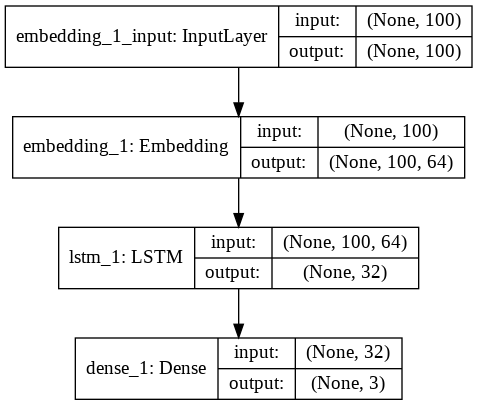

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
model.fit(train_x, dummy_train_y,
                 batch_size=16,
                 epochs=3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/3





19579/19579 [==============================] - 122s 6ms/step - loss: 1.0888 - acc: 0.4030
Epoch 2/3
19579/19579 [==============================] - 123s 6ms/step - loss: 1.0880 - acc: 0.4035
Epoch 3/3
19579/19579 [==============================] - 124s 6ms/step - loss: 1.0875 - acc: 0.4035


# Submission
0.47210 Private score

In [0]:
results = model.predict(test_x)
results = pd.DataFrame(results, columns=['EAP', 'HPL','MWS'])
results.insert(0, "id", ids)
results.to_csv("lstm_submission.csv", index=False)